## Access to the DB

### SQLite

In [1]:
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from churnmodels.schema import Subscription, Event, Account

# the following example will depend on a sqlite db
sqlfile="../churn.db"
engine = create_engine(f"sqlite:///{sqlfile}")
session = sessionmaker(bind=engine)()

### PostGres

In [5]:
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd

from churnmodels.schema import get_schema, get_db_uri

options = {"user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }
if False:
    # tables is a (dynamical) module containg Wrapper classes for our data base
    tables=get_schema(options)

    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    session = sessionmaker(bind=engine)()


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)



In [3]:
from sqlalchemy import func, or_
from churnmodels.schema import Account, Subscription, Event, EventType
import pandas as pd

d_start_date = "2020-01-01"
d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

## event_count (§3.1)

In [4]:
d_the_date = "2020-04-01"
the_date = datetime.strptime(d_the_date, "%Y-%m-%d")
inactivity_interval=relativedelta(months=+1)
the_date_int = the_date-inactivity_interval

q_event_count = session.query(Event.account_id, EventType.event_type_name, func.count(Event.account_id).label("n_event2measure_permonth"))\
    .filter(Event.event_time > the_date_int, Event.event_time <= the_date)\
    .join(EventType, EventType.event_type_id==Event.event_type_id)\
    .group_by(Event.account_id, EventType.event_type_name)

event_count = pd.read_sql(q_event_count.statement, engine) #.set_index("account_id")
#print(event_count)

# we do a pivot with pandas
df_pivot = event_count.pivot(index="account_id", columns="event_type_name", values="n_event2measure_permonth")
print(df_pivot)

event_type_name  adview  dislike   like  message  newfriend  post  reply  \
account_id                                                                 
1                  14.0      7.0    8.0     18.0        2.0  17.0   15.0   
2                  16.0     10.0   60.0      1.0        2.0  38.0    NaN   
4                  21.0      NaN   62.0     33.0        8.0  27.0   14.0   
5                   3.0      6.0   21.0     38.0        1.0  44.0   26.0   
6                  21.0      1.0    9.0    165.0        NaN   9.0   22.0   
...                 ...      ...    ...      ...        ...   ...    ...   
12096              26.0      9.0   60.0      3.0        5.0  18.0    2.0   
12097              11.0      8.0  107.0     67.0        1.0  23.0   15.0   
12098              58.0     53.0   50.0    108.0        2.0   7.0   19.0   
12099               1.0     47.0   64.0      NaN       14.0  17.0    NaN   
12100              10.0      4.0    4.0    146.0        NaN   4.0   68.0   

event_type_

## multi date count (§3.2)

In [30]:
# alternative to the interval functionality in postgres is to create a tempory table that can be joined to
from datetime import timedelta
def make_day_interval(d_start_date, d_end_date, periods, freq_str):
    # we let pandas do find the starting date which is
    # new-start-date = start-date - (periods * frequency)
    seq=pd.date_range(d_start_date, periods=periods+1, freq=f"-{freq_str}")
    new_start_date=seq[-1]
    end_dates=pd.date_range(d_start_date, d_end_date, freq=freq_str)
    start_dates=pd.date_range(new_start_date, periods=len(end_dates), freq=freq_str)
    df=pd.DataFrame({"start_date":start_dates,"end_date":end_dates})
    df.index.rename("id")
    return df 

#example
res=make_day_interval(d_start_date, d_end_date, 4, "7D")
print(res)


  start_date   end_date
0 2020-02-02 2020-03-01
1 2020-02-09 2020-03-08
2 2020-02-16 2020-03-15
3 2020-02-23 2020-03-22
4 2020-03-01 2020-03-29


In [32]:
# making the Date Intervals available in the data base
# example
freq="7D" # week has 7 days
periods=4 # 4 weeks back in time
days_df=make_day_interval(d_start_date, d_end_date, periods, freq)

# storing a temporary table to the data base with pandas
days_df.to_sql("tmp_days_vec",con=engine, if_exists='replace',  index_label='id')

# how to get a proper Table class for the temporary Table
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Table, MetaData
TmpDaysVec = Table('tmp_days_vec', MetaData(), autoload=True, autoload_with=engine)

# example
qddf=session.query(TmpDaysVec)
ddf=pd.read_sql(qddf.statement, engine)
print(ddf)

   id start_date   end_date
0   0 2020-02-02 2020-03-01
1   1 2020-02-09 2020-03-08
2   2 2020-02-16 2020-03-15
3   3 2020-02-23 2020-03-22
4   4 2020-03-01 2020-03-29


In [91]:
# transform to sqlalchemy
# multi_date_count (listing 3.2)
"""
select account_id, metric_date, count(*) as n_%event2measure
from event e inner join date_vals d
    on e.event_time < metric_date
    and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""

# we excercise §3.5 here as well (listing 3.5)
"""
select account_id, metric_date::date, sum(%field2sum) as sum_%event2measure_%field2sum
from event e inner join date_vals d    
	on e.event_time < metric_date 
	and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""
from sqlalchemy import and_
from churnmodels.schema import Event, EventType

q_multi_date_count=session.query(Event.account_id, EventType.event_type_id, EventType.event_type_name,
                 func.count(Event.event_time).label("metric_value"), 
                 (TmpDaysVec.c.end_date).label("metric_time"),
                 #TmpDaysVec.c.id, #TmpDaysVec.c.start_date, TmpDaysVec.c.end_date
                )\
    .join(TmpDaysVec, and_(Event.event_time>=TmpDaysVec.c.start_date, Event.event_time<TmpDaysVec.c.end_date))\
    .join(EventType, Event.event_type_id==EventType.event_type_id )\
    .group_by(Event.account_id, EventType.event_type_id, TmpDaysVec.c.id)\
    .order_by(Event.account_id, EventType.event_type_id, TmpDaysVec.c.id) #\
    #.filter(Event.account_id==2, Event.event_type_id==5)

multi_date_count=pd.read_sql(q_multi_date_count.statement, engine)
print(multi_date_count)



        account_id  event_type_id event_type_name  metric_value metric_time
0                1              1            post            16  2020-03-01
1                1              1            post            18  2020-03-08
2                1              1            post            13  2020-03-15
3                1              1            post            15  2020-03-22
4                1              1            post            13  2020-03-29
...            ...            ...             ...           ...         ...
380604       12100              5         dislike             4  2020-03-29
380605       12100              7         message            60  2020-03-22
380606       12100              7         message           124  2020-03-29
380607       12100              8           reply            19  2020-03-22
380608       12100              8           reply            56  2020-03-29

[380609 rows x 5 columns]


## metric insert (§3.3)

In [98]:
"""
insert into metric (account_id,metric_time,metric_name_id,metric_value)
select account_id, metric_date, %new_metric_id,  count(*) AS metric_value
from event e inner join date_vals d
on e.event_time < metric_date 
and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
"""
from churnmodels.schema import Event, EventType, Metric
from sqlalchemy.sql.expression import literal_column
from sqlalchemy import select, Integer

# the id of the metric to be calculated
#new_metric_id=1

# delete all old values "new_metric_id"
old_metrics=session.query(Metric)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# reuse the query from section from previous section
subq=q_multi_date_count.subquery()
#const_metric_name_id=literal_column(f"{new_metric_id}", Integer).label("metric_name_id")
const_metric_name_id=subq.c.event_type_id.label("metric_name_id")
select_stm=select([subq.c.account_id, subq.c.metric_time, const_metric_name_id, subq.c.metric_value])
columns=['account_id', 'metric_time', 'metric_name_id', 'metric_value']
session.execute(Metric.__table__.insert().from_select(columns, select_stm))
session.commit()



## adding new metric (§3.4)

In [110]:
# this step should be exercised before §3.3 to have a new metric id
"""
insert into metric_name values (%new_metric_id,'%new_metric_name')
"""
from sqlalchemy import func
from churnmodels.schema import MetricName
# finding the last index
#max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
#max_id+=1

# we simply delete old metrics
old_metrics=session.query(MetricName)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# ... and add the new ones
max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
new_metrics=session.query(EventType).order_by(EventType.event_type_id).all()
for row in new_metrics:
    max_id+=1
    session.execute(MetricName.__table__.insert(), {"metric_name": row.event_type_name, "metric_name_id":max_id})
session.commit()


    
    

## summing up the metric (§3.5)

In [96]:
# see §3.2
"""
select account_id, metric_date::date, sum(%field2sum) as sum_%event2measure_%field2sum
from event e inner join date_vals d    
	on e.event_time < metric_date 
	and e.event_time >= metric_date - interval '28 day'
inner join event_type t on t.event_type_id=e.event_type_id
where t.event_type_name='%event2measure'
group by account_id, metric_date
order by account_id, metric_date;
"""
pass



## metric staticstics over time (§3.6)

In [150]:
"""
from generate_series('%from_yyyy-mm-dd', '%to_yyyy-mm-dd', '7 day'::interval) i
), the_metric as (  
	select * from metric m
	inner join metric_name n on m.metric_name_id = n.metric_name_id
	where n.metric_name = '%metric2measure'
)
select calc_date,  avg(metric_value), count(the_metric.*) as n_calc,
min(metric_value), max(metric_value)    
from date_range left outer join the_metric on calc_date=metric_time     
group by calc_date     
order by calc_date    
"""


q_metric_stats_over_time_sub=session.query(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time,\
                func.avg(Metric.metric_value).label("avg"),\
                func.sum(Metric.metric_value).label("n_calc"),
                func.min(Metric.metric_value).label("min"),\
                func.max(Metric.metric_value).label("max"))\
    .join(MetricName, Metric.metric_name_id==MetricName.metric_name_id)\
    .group_by(Metric.metric_name_id, Metric.metric_time)\
    .order_by(Metric.metric_name_id, Metric.metric_time)
subq=q_metric_stats_over_time_sub.subquery()
q_metric_stats_over_time=session.query(subq.c.metric_name_id, 
                subq.c.metric_name, subq.c.metric_time.label("calc_date"), 
                subq.c.n_calc, subq.c.avg, subq.c.min, subq.c.max)

metric_stats_over_time=pd.read_sql(q_metric_stats_over_time.statement, engine)
print(metric_stats_over_time)


    metric_name_id metric_name  calc_date     n_calc        avg  min      max
0                1        post 2020-03-01   410271.0  38.921450  1.0   2013.0
1                1        post 2020-03-08   422822.0  39.656912  1.0   3575.0
2                1        post 2020-03-15   430208.0  39.900575  1.0   5061.0
3                1        post 2020-03-22   435477.0  39.977692  1.0   6072.0
4                1        post 2020-03-29   443608.0  40.475182  1.0   6136.0
5                2   newfriend 2020-03-01    67105.0   7.114610  1.0    125.0
6                2   newfriend 2020-03-08    68437.0   7.199348  1.0    123.0
7                2   newfriend 2020-03-15    69675.0   7.198574  1.0    114.0
8                2   newfriend 2020-03-22    70917.0   7.259392  1.0    114.0
9                2   newfriend 2020-03-29    71811.0   7.271264  1.0    122.0
10               3        like 2020-03-01   948848.0  88.264930  1.0   9969.0
11               3        like 2020-03-08   974164.0  89.784700 

## plotting the statics (§3.7)

['dislike', 'newfriend', 'message', 'reply', 'post', 'unfriend', 'like', 'adview']


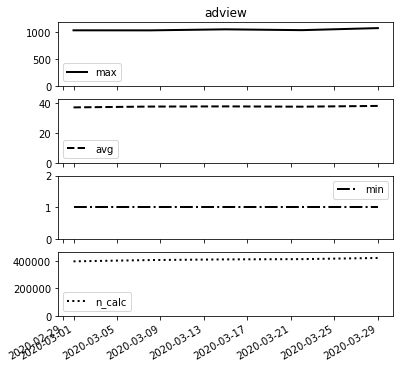

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def metric_qa_plot(qa_data_df, metric_name,**kwargs):
    #metric_data_path = qa_data_path + '_' + metric_name + '.csv'
    #qa_data_df=pd.read_csv(metric_data_path)
    plt.figure(figsize=(6, 6))
    qa_subplot(qa_data_df,'max',1,None)
    plt.title(metric_name)
    qa_subplot(qa_data_df,'avg',2,'--')
    qa_subplot(qa_data_df,'min',3,'-.')
    qa_subplot(qa_data_df,'n_calc',4,':')
    plt.gca().figure.autofmt_xdate()
    return plt

def qa_subplot(qa_data_df, field, number, linestyle):
    plt.subplot(4, 1, number)
    plt.plot('calc_date', field, data=qa_data_df, marker='', linestyle=linestyle, color='black', linewidth=2, label=field)
    plt.ylim(0, ceil(1.1 * qa_data_df[field].dropna().max()))
    plt.legend()

metricslist=list(metric_stats_over_time["metric_name"].value_counts().index)
print(metricslist)
title="adview"
metric_qa_plot(metric_stats_over_time.loc[metric_stats_over_time["metric_name"]==title], title)
pass


## data coverage (§3.8)

In [163]:
"""
with 
date_range as (     
	select  '%from_yyyy-mm-dd'::timestamp as start_date,
		'%to_yyyy-mm-dd'::timestamp as end_date
), account_count as (    
	select count(distinct account_id) as n_account    
	from subscription s inner join date_range d on
	 s.start_date <= d.end_date
	and (s.end_date >= d.start_date or s.end_date is null)
)
select metric_name, 
	count(distinct m.account_id) as count_with_metric,
	n_account as n_account,    
	(count(distinct m.account_id))::float/n_account::float as pcnt_with_metric    ,
	avg(metric_value) as avg_value,    
	min(metric_value) as min_value,    
	max(metric_value) as max_value,
	min(metric_time)  as earliest_metric,
	max(metric_time) as last_metric
from metric m cross join account_count
inner join date_range on    
	metric_time >= start_date
	and metric_time <= end_date
inner join metric_name  n on m.metric_name_id = n.metric_name_id
inner join subscription s on s.account_id = m.account_id
    and s.start_date <= m.metric_time
    and (s.end_date >= m.metric_time or s.end_date is null)
group by metric_name,n_account
order by metric_name;
"""

#q_account_count = session.query(func.count(Subscription.account_id).label("n_account"))\
#    .filter(Subscription.start_date <= d_end_date,
#           or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
#    .group_by(Subscription.account_id) 
#account_count = pd.read_sql(q_account_count.statement, engine)
#print(account_count)
q_account_count = session.query(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time,\
                func.count(Metric.account_id).label("count_with_metric"),\
                func.avg(Metric.metric_value).label("avg"),\
                func.sum(Metric.metric_value).label("n_calc"),
                func.min(Metric.metric_value).label("min"),\
                func.max(Metric.metric_value).label("max"))\
    .filter(Subscription.start_date <= d_end_date,
           or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
    .group_by(Subscription.account_id) 
account_count = pd.read_sql(q_account_count.statement, engine)
print(account_count)




       n_account
0              2
1              2
2              2
3              2
4              2
...          ...
11491          1
11492          1
11493          1
11494          1
11495          1

[11496 rows x 1 columns]
